# Model Inputs

### Packages

In [1]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import umap
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Classfication
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Visualization
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [2]:
# Loading output dataframe from data.ipynb
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

# Filter non-specific ec numbers (e.g., 1.1.1,-)
filter = df["ec"].str.contains("-")
df = df[~filter]

# Format for machine learning
df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]
df_test = df[bins]

### Split dataset

In [3]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Test case with MAGs
X_train = df_train.drop(["taxon_id", "media_id"], axis=1)
y_train = df_train[TARGET] 
X_test = df_test.drop(["taxon_id", "media_id"], axis=1)
y_test = df_test[TARGET]

# Model

### Pipeline

In [4]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Scale data (optional)
    ('pca', PCA(n_components=120)),   # Reduce dimensionality with PCA
    ('umap', umap.UMAP(              # Further reduce with UMAP
        metric="euclidean",
        n_epochs=200, #200 recommended for large datasets, higher => stricter clustering
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=30, 
        n_neighbors=40, 
        min_dist=0.4 
        )) 
]) 

### Fit and transform

In [5]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Cluster

In [24]:
# Cluster
clusterer = KMeans(n_clusters=179, random_state=RANDOM_SEED) #173, 177, 181, 185
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [25]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
#print(f"PCA explained variance: {explained_variance}") # variance of each component
print(f"Total PCA explained variance: {explained_variance.sum()}")

# Further dimensionality reduction and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}") # <0.25 implies poor clustering, 0.25<x<0.50 is fair, >50 is good
#84, 177, 68

Total PCA explained variance: 0.8421884718701971
179 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.6473733186721802


# Classifier

In [8]:
y2_train = cluster_labels
y2_test = test_clusters

### Random Forest

In [9]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

rfc.fit(X_train_transformed, y2_train)
print(rfc.predict(X_test_transformed))

[150 150 150  96 150 150 150  68  96 150 151 150 151 151 150 171  68 150
 178  68 151   2 150 151 151 150  96 150 150  68   2  96 143 150  68 150
 151 150 150 150 151 150 150  96  68 150  68 150  96 150 151 171 151 150
 150 150 143 150  96 110 151 150 150 150 151 171  68 150 150 151 150 110
 150  96  68 175 150 150 151 150 150 150  68 151   2 151 150 151   2 143
 150 150 150 101 150 151 150  46  68  29   2   2   2 150 150 151  96  68
  68 150 150 151 150  96 151 150 150 150 150 150 150 171 150 150 150  68
 150 150 178 151 150 150 151 110 171   2 150 150  96 150  96 150  68  46
 110   2 150 150   2 150 151  68 150 150 150 150   2 110  96  96 151 151
  96 150 143 171 150   2 150 150   2 150 108 150 150 151  96  68 150 151
  68 150 150 150  68 151 150 150 150 151 150 150 150  96 171 150 150 171
 150 178 150 150 178 151 171 150 151  96 150 150 173 150 171 150  96 151
  96 178 150 150  96 150   2 171 171   2 150 171 150 151  29 171 150 171
 150 150 171  96 171 178 150  68 151 150 150 150 17

In [10]:
report = classification_report(
    y_true=y2_test,
    y_pred=rfc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=rfc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("RF ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        16
          29       1.00      0.67      0.80         3
          46       1.00      1.00      1.00         2
          68       0.60      0.92      0.73        13
          96       0.55      0.92      0.69        13
         101       1.00      1.00      1.00         1
         108       1.00      1.00      1.00         1
         110       1.00      1.00      1.00         5
         143       1.00      1.00      1.00         4
         150       0.95      0.86      0.90       126
         151       0.89      0.79      0.84        39
         171       1.00      1.00      1.00        17
         173       0.00      0.00      0.00         0
         175       0.00      0.00      0.00         0
         178       1.00      1.00      1.00         7

    accuracy                           0.88       247
   macro avg       0.80      0.81      0.79       247
weighted avg       0.91   

### Nearest Neighbors

In [11]:
knc= KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train_transformed, cluster_labels)
distances, indices = knc.kneighbors(X_test_transformed)

print(knc.predict(X_test_transformed))

[150 150 150 150 150 150 151  68 150 150 151 150 151 151 150 171  68 150
 178 151 151   2 150 151 151 150 150 150 151 151 171  68 143 150 151  68
 151 150 150 150 151 150 150  96  68 150  68 150 150 150 151 171 151 150
 150 150 143 150  96 110 151 150 150 150 151 171 151 150 150 151 150 110
 150 150  68  29 150 150 151 150 151 150 151 151   2 151 150 151   2 143
 150 150 150 101 150 151 150  46  68  29 171   2   2 150 150 151  96  68
 151 150 150 151 151  96 151 150 151 150 150 150 150 171 150 150 150  68
 150 150 178 151 150 150 151 110 171   2 150 150  96 151 150 151  68  46
 110   2 150 151   2  96 151 151 150 151 150 150   2 110  96  96 151 151
 150 150 143 171 151   2 151 150   2 150 108 150 150 151 150  68 151 151
  68 150 150 150  68 151 150 150 151 151 150 150 150  96 171 150 150 171
 150 178 151 150 178 151 171 150 151 150 150 151 173 150 171 150 150 151
  96 178 150 150  96 151 171 171 171 171 150 171 150 151  29 171  68 171
 150 150 171  96 171 178 151 151 151 151 150 150 17

In [12]:
report = classification_report(
    y_true=y2_test,
    y_pred=knc.predict(X_test_transformed),
    zero_division=0.0 # Default: set to "warn", or float {0.0, 1.0}
)

roc_score = metrics.roc_auc_score(
    y_true=y2_test,
    y_score=knc.predict_proba(X_test_transformed),
    labels=np.unique(y2_train),
    average="weighted",
    multi_class="ovo"
)

print(report)
print("KNN ROC AUC score:", roc_score)

              precision    recall  f1-score   support

           2       1.00      0.69      0.81        16
          29       1.00      1.00      1.00         3
          46       1.00      1.00      1.00         2
          68       0.67      0.77      0.71        13
          96       0.83      0.77      0.80        13
         101       1.00      1.00      1.00         1
         108       1.00      1.00      1.00         1
         110       1.00      1.00      1.00         5
         143       1.00      1.00      1.00         4
         150       0.98      0.80      0.88       126
         151       0.64      1.00      0.78        39
         171       0.81      1.00      0.89        17
         173       0.00      0.00      0.00         0
         178       1.00      1.00      1.00         7

    accuracy                           0.85       247
   macro avg       0.85      0.86      0.85       247
weighted avg       0.89      0.85      0.86       247

KNN ROC AUC score: 0.9814

# Outputs

### Train, clustering labels

In [13]:
# Training data
train_df = pd.DataFrame(X_train_transformed, columns=[f"Component {i+1}" for i in range(X_train_transformed.shape[1])])
train_df['Set'] = 'Training'
train_df['Target'] = y_train
train_df['KMeans Cluster'] = cluster_labels
train_df['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_df['Media Cluster'] = train_df['Target'].map(target_label_mapping)

train_df.to_csv(os.path.join(DATA_DIR, "model", "train-output.csv"), index=False)
train_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 26,Component 27,Component 28,Component 29,Component 30,Set,Target,KMeans Cluster,taxon_id,Media Cluster
0,8.782784,5.898263,5.757063,5.833907,4.608732,5.178930,5.552777,3.216833,6.436071,3.635296,...,4.745279,5.220063,4.854875,5.107325,4.176115,Training,J346,132,100.0,9.0
1,9.710889,6.151599,5.426264,5.512591,4.915431,4.459331,5.302310,4.438601,5.520103,6.693969,...,4.722345,4.527818,4.498508,4.942034,5.484147,Training,J386,127,100.0,9.0
2,9.103703,5.739976,5.574826,4.700190,5.615321,4.226705,5.428749,4.937512,1.915106,4.324176,...,6.601743,6.141792,5.286640,7.200780,8.749250,Training,J233,171,100225.0,2.0
3,9.441509,5.834457,6.077092,3.207303,4.775804,5.053038,4.847644,4.715306,2.816186,3.728853,...,4.849342,4.921975,5.052269,3.037976,5.698209,Training,J22,92,1002526.0,0.0
4,9.355459,6.033092,4.971431,5.707638,5.029323,3.740600,4.815808,5.892961,3.886589,6.150769,...,6.460471,6.168915,5.630143,5.550895,6.739913,Training,1a,168,1004166.0,9.0


### Test, classifier labels

In [14]:
# Test data
test_df = pd.DataFrame(X_test_transformed, columns=[f"Component {i+1}" for i in range(X_test_transformed.shape[1])])
test_df['Set'] = 'Test'
test_df['Target'] = list(df_test['media_id'])
test_df['KMeans Cluster'] = test_clusters
test_df['taxon_id'] = list(df_test['taxon_id'])

# Add classifier labels 
test_df["KNN Classify"] = knc.predict(X_test_transformed)
test_df["RF Classify"] = rfc.predict(X_test_transformed)

test_df.to_csv(os.path.join(DATA_DIR, "model", "test-output.csv"), index=False)
test_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Component 27,Component 28,Component 29,Component 30,Set,Target,KMeans Cluster,taxon_id,KNN Classify,RF Classify
0,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,5.722295,5.761506,5.623385,7.721004,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150
1,9.547881,5.889443,5.054542,5.358310,4.963970,4.143116,5.126888,5.423056,3.656497,4.830527,...,5.754050,5.766644,5.635114,7.742245,Test,unknown,150,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,150,150
2,9.592621,5.886361,5.062726,5.398075,4.924161,4.123317,5.137332,5.394005,3.780892,4.885144,...,5.737384,5.780976,5.618332,7.672289,Test,unknown,150,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,150,150
3,9.541341,5.974868,5.087275,5.294192,4.994914,4.190461,5.030763,5.646428,3.855206,5.005189,...,5.635773,5.697612,5.475749,7.578447,Test,unknown,150,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,150,96
4,9.508337,5.921252,5.078369,5.314478,4.981223,4.077504,5.062564,5.509960,3.350663,4.953013,...,5.645106,5.660184,5.561357,7.614805,Test,unknown,150,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,150,150


### ID nearest neighbors

In [15]:
# Add nearest neighbor indices to the test dataframe
knn_df = test_df.copy()
knn_df = knn_df.rename(columns={"KMeans Cluster": "Test Cluster"})
neighbors = pd.DataFrame(indices) # Indices of nearest neighbors from the training set
knn_df['indices'] = neighbors[neighbors.columns[0:]].apply(lambda x: ';'.join(x.dropna().astype(str)), axis=1)
knn_df["indices"] = knn_df["indices"].str.split(';')
knn_df = knn_df.explode("indices")

# Add original indices as a column for the train dataframe
train_index = train_df.copy()
train_index = train_index.rename(columns={"KMeans Cluster": "Train Cluster"})
train_index["indices"] = df_train.index
train_index["indices"] = train_index["indices"].astype(str)

# Merge to label nearest neighbors
left = knn_df.copy()
right = train_index[["indices", "Target", "taxon_id", "Media Cluster"]]
right = right.rename(columns={"Target": "neighbor_media_id", "taxon_id": "neighbor_taxon_id", "Cluster": "neighbor_cluster"})
merged = pd.merge(left, right, on="indices", how="left")

merged.to_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"), index=False)
merged

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,...,Set,Target,Test Cluster,taxon_id,KNN Classify,RF Classify,indices,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150,5667,J84,38402.0,9.0
1,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150,7921,J237,75385.0,NaN
2,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150,2863,J256,1901.0,9.0
3,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150,5126,J84,33034.0,9.0
4,9.566709,5.879142,5.020658,5.346295,4.943074,4.068261,5.094788,5.370131,3.575392,4.875126,...,Test,unknown,150,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,150,150,5125,J156,33034.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,9.759860,5.905958,5.195092,5.535030,4.923949,4.021317,5.381134,5.079380,2.989364,4.703263,...,Test,unknown,178,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,178,178,5449,J14,363265.0,8.0
1231,9.759860,5.905958,5.195092,5.535030,4.923949,4.021317,5.381134,5.079380,2.989364,4.703263,...,Test,unknown,178,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,178,178,5450,J84,363265.0,9.0
1232,9.759860,5.905958,5.195092,5.535030,4.923949,4.021317,5.381134,5.079380,2.989364,4.703263,...,Test,unknown,178,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,178,178,5447,1203a,363265.0,9.0
1233,9.759860,5.905958,5.195092,5.535030,4.923949,4.021317,5.381134,5.079380,2.989364,4.703263,...,Test,unknown,178,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,178,178,5448,J13,363265.0,9.0


# Visualization

### Feature importance

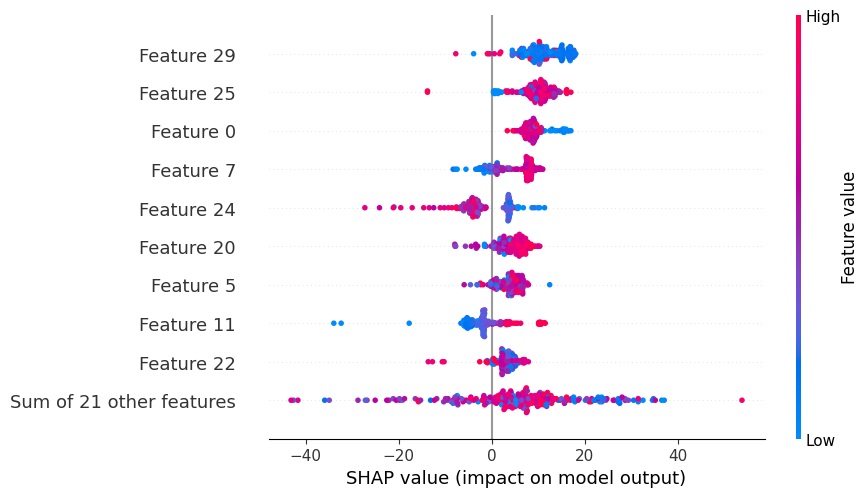

In [33]:
import xgboost
import shap

XG_train = X_train_transformed
yG_train = cluster_labels
XG_test = X_test_transformed
yG_test = test_clusters

# train an XGBoost model
model1 = xgboost.XGBRegressor().fit(XG_train, yG_train)
#model2 = xgboost.XGBRegressor().fit(XG_test, yG_test)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model1)
shap_values = explainer(XG_test)

shap.plots.initjs()
shap.plots.beeswarm(shap_values)

### n dimensions

In [37]:
# Plot the training points
fig = px.scatter(
    data_frame = train_df,
    x = "Component 30",
    y = "Component 26", # Change components to visualize each of the 30 dimensions
    color = "Media Cluster",
    hover_data = ["taxon_id", "Target", "KMeans Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_df["Component 30"],  # x coordinates
        y=test_df["Component 26"],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_df["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="KMeans Clustering",
    template="plotly_white",
)

fig.show()

### 2 dimensions

#### 2D Pipeline

In [18]:
# copy of model pipeline reduced to two dimensions, ***LEADS TO DISCONNECT IN DIMENSIONALITY REDUCTION STEPS***
visualization = Pipeline([
    ('scaler', StandardScaler()),   
    ('pca', PCA(n_components=120)),   
    ('umap', umap.UMAP(              
        metric="euclidean",
        n_epochs=200, 
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=2, # reduced for visualization
        n_neighbors=40, 
        min_dist=0.4 
        )) 
]) 

# Fit and transform the pipeline on the training and test data
X_train_embedding = visualization.fit_transform(X_train) # fit pipeline and transform training data
X_test_embedding = visualization.transform(X_test) # transform test data

# Cluster
vclusterer = KMeans(n_clusters=180, random_state=RANDOM_SEED)
vcluster_labels = vclusterer.fit_predict(X_train_embedding)
vtest_clusters = vclusterer.predict(X_test_embedding)

# Metrics to compare to 30 dimensions
vpca = visualization.named_steps['pca']
vexplained_variance = vpca.explained_variance_ratio_
vsilhouette_avg = silhouette_score(X_train_embedding, vcluster_labels)
print(f"Total PCA explained variance: {vexplained_variance.sum()}")
print(vclusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {vsilhouette_avg}") # <0.25 implies poor clustering, 0.25<x<0.50 is fair, >50 is good

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\umap\spectral.py:550: UserWarning:

Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



Total PCA explained variance: 0.8421847987242764
180 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.6682138442993164


#### Visualization

In [19]:
# Training data
train_2d = pd.DataFrame(X_train_embedding, columns=[f"Component {i+1}" for i in range(X_train_embedding.shape[1])])
train_2d['Set'] = 'Training'
train_2d['Target'] = y_train
train_2d['KMeans Cluster'] = cluster_labels
train_2d['taxon_id'] = df_train["taxon_id"]

# Media cluster labels
media_clusters = pd.read_csv(os.path.join(DATA_DIR, "model", "media-clusters.csv"))
media_clusters = media_clusters[["media_id", "Cluster"]]
media_clusters = media_clusters.rename(columns={"media_id": "Target", "Cluster": "Media Cluster"})
target_label_mapping = dict(zip(media_clusters['Target'], media_clusters['Media Cluster']))
train_2d['Media Cluster'] = train_2d['Target'].map(target_label_mapping)

# Test data
test_2d = pd.DataFrame(X_test_embedding, columns=[f"Component {i+1}" for i in range(X_test_embedding.shape[1])])
test_2d['Set'] = 'Test'
test_2d['Target'] = list(df_test['media_id'])
test_2d['KMeans Cluster'] = test_clusters
test_2d['taxon_id'] = list(df_test['taxon_id'])

In [40]:
# Plot the training points
fig = px.scatter(
    data_frame = train_2d,
    x = "Component 1",
    y = "Component 2", # Change components to visualize each of the 30 dimensions
    color = "Media Cluster",
    hover_data = ["taxon_id", "Target", "KMeans Cluster"],
    opacity = 0.3
) 

# Add the test points as a scatter trace
fig.add_trace(
    go.Scatter(
        x=test_2d["Component 1"],  # x coordinates
        y=test_2d["Component 2"],  # y coordinates
        mode='markers',
        marker=dict(
            color='black',  
            size=5,  
            opacity=1.0 
        ),
        text=test_2d["taxon_id"]  # marker hover text
    )
)

# Opacity slider
steps = []
for i in range(11):  # 0 to 1 in steps of 0.1
    step = dict(
        method="restyle",
        args=[{"marker.opacity": [i/20]}, [0]],  # Adjust opacity of the first trace only
        label=str(i/20)
    )
    steps.append(step)
sliders = [dict(
    active=3,  # initial value corresponding to opacity=0.3
    currentvalue={"prefix": "Opacity: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="2 Dimensions",
    template="plotly_white",
)

fig.show()